# SeFa Implementation

## Fetch Codebase and Models

In [1]:
import os
import sys

if os.path.exists('/content'):
    os.chdir('/content')
    CODE_DIR = 'SeFaInvert'
    if not os.path.exists(CODE_DIR):
        !git clone https://github.com/MrLishu/GANInvert.git $CODE_DIR
    os.chdir(f'./{CODE_DIR}')

Cloning into 'SeFaInvert'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 55 (delta 12), reused 48 (delta 5), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [3]:
MODEL_DIR = os.path.join('models', 'pretrain')
os.makedirs(MODEL_DIR, exist_ok=True)
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EXqix_JIEgtLl1FXI4uCkr8B5GPaiJyiLXL6cFbdcIKqEA?e=WYesel\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_encoder.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EbuzMQ3ZLl1AqvKJzeeBq7IBoQD-C1LfMIC8USlmOMPt3Q?e=CMXn8W\&download\=1 -O $MODEL_DIR/styleganinv_ffhq256_generator.pth  --quiet
!wget https://mycuhk-my.sharepoint.com/:u:/g/personal/1155082926_link_cuhk_edu_hk/EQJUz9DInbxEnp0aomkGGzAB5b3ZZbtsOA-TXct9E4ONqA?e=smtO0T\&download\=1 -O $MODEL_DIR/vgg16.pth  --quiet

## Import StyleGAN and GAN Inverter

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from utils.inverter import StyleGANInverter
from models.face_landmark_detector import FaceLandmarkDetector

inverter = StyleGANInverter('styleganinv_ffhq256', learning_rate=0.01, iteration=100,
                            reconstruction_loss_weight=1.0, perceptual_loss_weight=5e-5, regularization_loss_weight=0)
generator = inverter.G
resolution = inverter.G.resolution

def align(image_name):
    face_landmark_detector = FaceLandmarkDetector(resolution)
    face_infos = face_landmark_detector.detect(os.path.join('images', image_name))[0]
    image = face_landmark_detector.align(face_infos)
    return image

[2021-06-23 05:38:54,554][INFO] Build network for module `generator` in model `styleganinv_ffhq256`.
[2021-06-23 05:38:54,886][INFO] Loading pytorch weights from `models/pretrain/styleganinv_ffhq256_generator.pth`.
[2021-06-23 05:38:55,141][INFO] Successfully loaded!
[2021-06-23 05:39:06,902][INFO] Current `lod` is 0.0.
[2021-06-23 05:39:06,903][INFO] Build network for module `encoder` in model `styleganinv_ffhq256`.
[2021-06-23 05:39:08,063][INFO] Loading pytorch weights from `models/pretrain/styleganinv_ffhq256_encoder.pth`.
[2021-06-23 05:39:09,403][INFO] Successfully loaded!


In [6]:
source_image_name = 'emma.png'
source_image = align(source_image_name)
source_image_code = inverter.easy_invert(source_image, 1)[0]

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
loss_pix: 0.011, loss_feat: 834.102, loss: 0.052: 100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


In [7]:
target_image_name = '000001.png'
target_image = align(target_image_name)
target_image_code = inverter.easy_invert(target_image, 1)[0]

loss_pix: 0.005, loss_feat: 481.081, loss: 0.029: 100%|██████████| 100/100 [00:10<00:00,  9.90it/s]


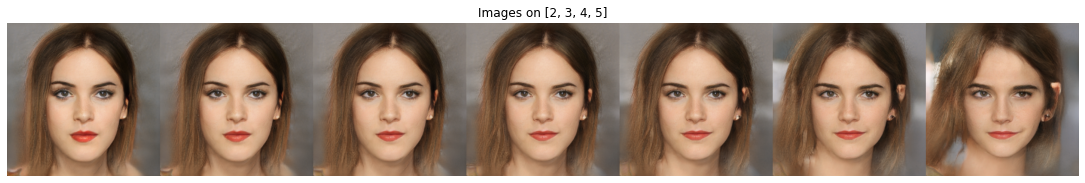

In [26]:
layer_low = 2 #@param {type:"slider", min:0, max:13, step:1}
layer_high = 5 #@param {type:"slider", min:0, max:13, step:1}
semantic = 1 #@param {type:"slider", min:1, max:10, step:1}

layers = list(range(layer_low, layer_high + 1))

weights = []
for layer in layers:
    weights.append(generator.net.synthesis.__getattr__(f'layer{layer}').epilogue.style_mod.dense.fc.weight.T.cpu().detach().numpy())
weight = np.concatenate(weights, axis=1).astype(np.float32)
weight = weight / np.linalg.norm(weight, axis=0, keepdims=True)
eigen_values, eigen_vectors = np.linalg.eig(weight.dot(weight.T))
boundaries = eigen_vectors.T
boundary = boundaries[semantic - 1]

sematic_up = 1.5 #@param {type:"slider", min:0, max:5, step:0.1}
sematic_down = -6 #@param {type:"slider", min:-10, max:0, step:0.1}
steps = 7 #@param {type:"slider", min:2, max:12, step:1}

new_codes = source_image_code.repeat(steps, axis=0).reshape(steps, generator.net.num_layers, -1)
new_codes[:, layers, :] += boundary.reshape(1, 1, -1) * np.linspace(sematic_down, sematic_up, steps, dtype=np.float32).reshape(-1, 1, 1)
new_images = generator.easy_synthesize(new_codes, latent_space_type='wp')['image']

plt.figure(figsize=(19.2, 10.8))
plt.axis("off")
plt.title(f"Images on {layers}")
plt.imshow(np.concatenate(new_images, axis=1))
plt.show()

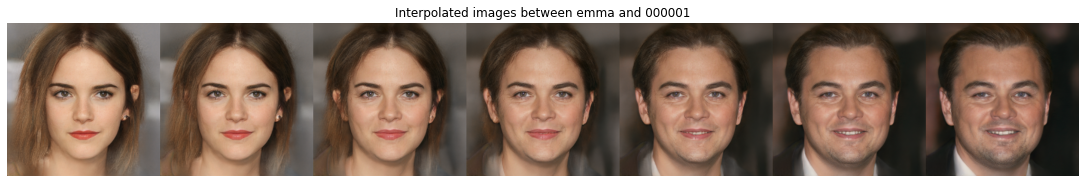

In [11]:
step = 7 #@param {type:"slider", min:2, max:12, step:1}

linspace = np.linspace(0, 1, step).reshape(-1, 1, 1).astype(np.float32)
inter_codes = (1 - linspace) * source_image_code + linspace * target_image_code
inter_images = generator.easy_synthesize(inter_codes, latent_space_type='wp')['image']

plt.figure(figsize=(19.2, 10.8))
plt.axis("off")
plt.title(f"Interpolated images between {source_image_name.split('.')[0]} and {target_image_name.split('.')[0]}")
plt.imshow(np.concatenate(inter_images, axis=1))
plt.show()

In [22]:
import cv2 as cv

def addManipulateImages(writer, layers, sematic, sematic_limits, duration=4):
  weights = []
  for layer in layers:
    weights.append(generator.net.synthesis.__getattr__(f'layer{layer}').epilogue.style_mod.dense.fc.weight.T.cpu().detach().numpy())
  weight = np.concatenate(weights, axis=1).astype(np.float32)
  weight = weight / np.linalg.norm(weight, axis=0, keepdims=True)
  eigen_values, eigen_vectors = np.linalg.eig(weight.dot(weight.T))
  boundaries = eigen_vectors.T
  boundary = boundaries[semantic]

  steps = int(duration / 2 * 24)
  linspace = np.r_[np.linspace(0, sematic_limits, steps, dtype=np.float32).reshape(-1, 1, 1),
             np.linspace(sematic_limits, 0, steps, dtype=np.float32).reshape(-1, 1, 1)]

  new_codes = source_image_code.repeat(steps * 2, axis=0).reshape(steps * 2, generator.net.num_layers, -1)
  new_codes[:, layers, :] += boundary.reshape(1, 1, -1) * linspace
  new_images = generator.easy_synthesize(new_codes, latent_space_type='wp')['image']

  for i in range(steps * 2):
    b, g, r = new_images[i].transpose(2, 0, 1)
    image = np.array([r, g, b]).transpose(1, 2, 0)
    writer.write(image)

def addInterpolateImages(writer, duration=4):
  steps = int(duration / 2 * 24)

  linspace = np.r_[np.linspace(0, 1, steps, dtype=np.float32).reshape(-1, 1, 1),
             np.linspace(1, 0, steps, dtype=np.float32).reshape(-1, 1, 1)]
  inter_codes = (1 - linspace) * source_image_code + linspace * target_image_code
  inter_images = generator.easy_synthesize(inter_codes, latent_space_type='wp')['image']

  for i in range(steps * 2):
    b, g, r = inter_images[i].transpose(2, 0, 1)
    image = np.array([r, g, b]).transpose(1, 2, 0)
    writer.write(image)

duration = 2
videowriter = cv.VideoWriter(os.path.join('videos', f'{source_image_name.split(".")[0]}.mp4'), cv.VideoWriter_fourcc(*'XVID'), 24, (resolution, resolution))
print(videowriter.isOpened())
addManipulateImages(videowriter, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], sematic=1, sematic_limits=2, duration=duration)
addManipulateImages(videowriter, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], sematic=1, sematic_limits=-4, duration=duration)
addManipulateImages(videowriter, [2, 3, 4], sematic=1, sematic_limits=4, duration=duration)
addManipulateImages(videowriter, [2, 3, 4], sematic=1, sematic_limits=-4, duration=duration)
addInterpolateImages(videowriter, duration=duration)
videowriter.release()

True
